# Analyzing Car Accidents in Canada from 1999 - 2014 using a distributed environment in PySpark

In [7]:
import pyspark as py
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import RandomForestClassifier

In [8]:
spark = SparkSession.builder.appName('analysis').getOrCreate()
df = spark.read.csv('NCDB_1999_to_2014.csv',header=True)
df.show(10,False)

+------+------+------+------+-----+------+------+------+------+------+------+------+----+------+------+----+-----+-----+-----+------+------+------+
|C_YEAR|C_MNTH|C_WDAY|C_HOUR|C_SEV|C_VEHS|C_CONF|C_RCFG|C_WTHR|C_RSUR|C_RALN|C_TRAF|V_ID|V_TYPE|V_YEAR|P_ID|P_SEX|P_AGE|P_PSN|P_ISEV|P_SAFE|P_USER|
+------+------+------+------+-----+------+------+------+------+------+------+------+----+------+------+----+-----+-----+-----+------+------+------+
|1999  |01    |1     |20    |2    |02    |34    |UU    |1     |5     |3     |03    |01  |06    |1990  |01  |M    |41   |11   |1     |UU    |1     |
|1999  |01    |1     |20    |2    |02    |34    |UU    |1     |5     |3     |03    |02  |01    |1987  |01  |M    |19   |11   |1     |UU    |1     |
|1999  |01    |1     |20    |2    |02    |34    |UU    |1     |5     |3     |03    |02  |01    |1987  |02  |F    |20   |13   |2     |02    |2     |
|1999  |01    |1     |08    |2    |01    |01    |UU    |5     |3     |6     |18    |01  |01    |1986  |01  |M   

In [9]:
print("Total Rows in Dataset:",df.select("*").count())

Total Rows in Dataset: 5860405


In [10]:
print("Name of Columns - Printing for reference")
df.schema.names

Name of Columns - Printing for reference


['C_YEAR',
 'C_MNTH',
 'C_WDAY',
 'C_HOUR',
 'C_SEV',
 'C_VEHS',
 'C_CONF',
 'C_RCFG',
 'C_WTHR',
 'C_RSUR',
 'C_RALN',
 'C_TRAF',
 'V_ID',
 'V_TYPE',
 'V_YEAR',
 'P_ID',
 'P_SEX',
 'P_AGE',
 'P_PSN',
 'P_ISEV',
 'P_SAFE',
 'P_USER']

In [11]:
###################
###Cleaning Data###
###################
df = df.select("*").filter(col("C_MNTH").cast("int").isNotNull())
df = df.select("*").filter(col("P_SAFE").cast("int").isNotNull())
df = df.select("*").filter(col("V_TYPE").cast("int").isNotNull())

# Total No. of Collisions together for a month.

In [12]:
collisions_month_together = df.select(col("C_MNTH").alias("Month")).groupBy("Month").count().sort("Month")
collisions_month_together.show(collisions_month_together.count(),False)

+-----+------+
|Month|count |
+-----+------+
|01   |387155|
|02   |328735|
|03   |323234|
|04   |302854|
|05   |358760|
|06   |396079|
|07   |412183|
|08   |418838|
|09   |389247|
|10   |394746|
|11   |383905|
|12   |410101|
+-----+------+



In [13]:
collisions_month_together_pandas_df = collisions_month_together.select("*").toPandas()

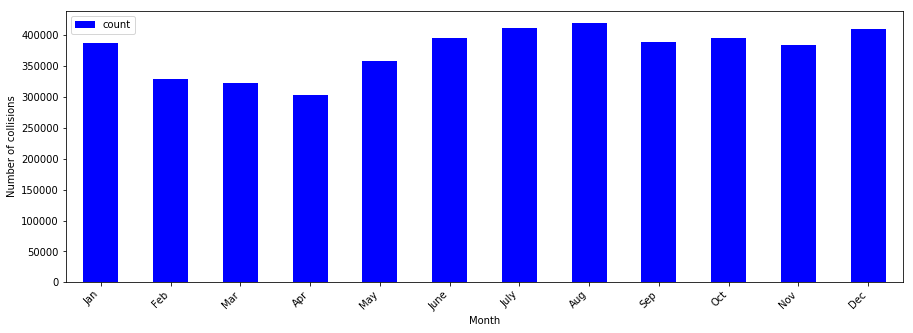

In [14]:
collisions_month_together = collisions_month_together_pandas_df.plot.bar(figsize=(15,5),color='blue')
month_arr = ["Jan","Feb","Mar","Apr","May","June","July","Aug","Sep","Oct","Nov","Dec"]
collisions_month_together.set_xticklabels(month_arr,ha='right',rotation = 45)
collisions_month_together.set_xlabel("Month")
collisions_month_together.set_ylabel("Number of collisions");

# Collisions grouped by the Day of Week

In [15]:
collisions_week_together = df.select(col("C_WDAY").alias("Day")).filter(col("Day") != "U").groupBy("Day").count().sort("Day")
collisions_week_together.show(collisions_week_together.count(),False)

+---+------+
|Day|count |
+---+------+
|1  |596751|
|2  |623646|
|3  |628403|
|4  |661659|
|5  |766958|
|6  |676423|
|7  |551477|
+---+------+



In [16]:
collisions_week_together_pandas_df = collisions_week_together.select("*").toPandas()

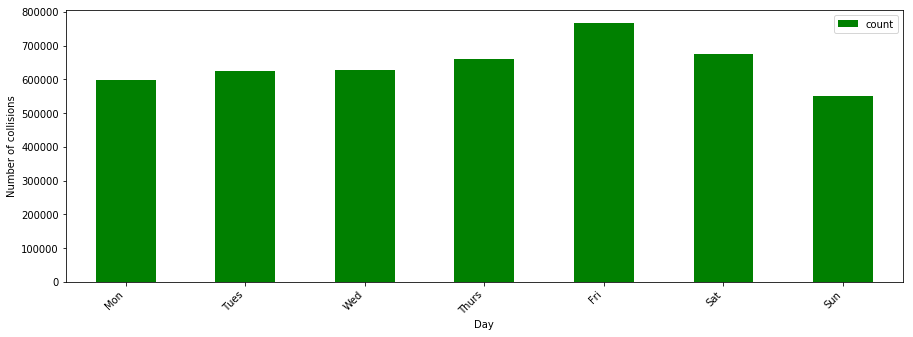

In [17]:
collisions_week_together = collisions_week_together_pandas_df.plot.bar(figsize=(15,5),color='green')
day_arr = ["Mon","Tues","Wed","Thurs","Fri","Sat","Sun"]
collisions_week_together.set_xticklabels(day_arr,ha='right',rotation = 45)
collisions_week_together.set_xlabel("Day")
collisions_week_together.set_ylabel("Number of collisions");

# Collisions grouped by the Hour of Day

In [18]:
collisions_hour_together = df.select(col("C_HOUR").alias("Hour")).filter(col("Hour") != "UU").groupBy("Hour").count().sort("Hour")
collisions_hour_together.show(5,False)

+----+-----+
|Hour|count|
+----+-----+
|00  |65992|
|01  |53894|
|02  |54903|
|03  |46223|
|04  |29643|
+----+-----+
only showing top 5 rows



In [19]:
collisions_hour_together_pandas_df = collisions_hour_together.select("*").toPandas()

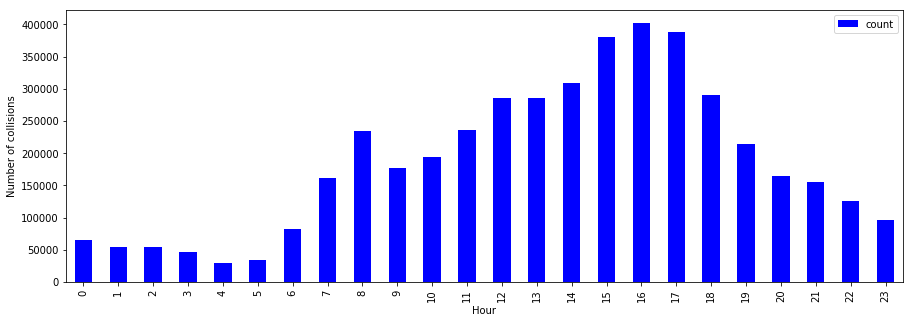

In [20]:
collisions_hour_together = collisions_hour_together_pandas_df.plot.bar(figsize=(15,5), label = "Bar" ,color='blue')

collisions_hour_together.set_xlabel("Hour")
collisions_hour_together.set_ylabel("Number of collisions");

# Total No. of collisions in a month for each month seperately

In [21]:
collisions_month = df.select(concat(col("C_YEAR"), lit("-"), col("C_MNTH")).alias("Date")).groupBy("Date").count().sort("Date")
collisions_month.show(5,False)

+-------+-----+
|Date   |count|
+-------+-----+
|1999-01|25650|
|1999-02|20557|
|1999-03|22651|
|1999-04|21926|
|1999-05|27384|
+-------+-----+
only showing top 5 rows



In [22]:
collisions_month_pandas_df = collisions_month.select("*").toPandas()

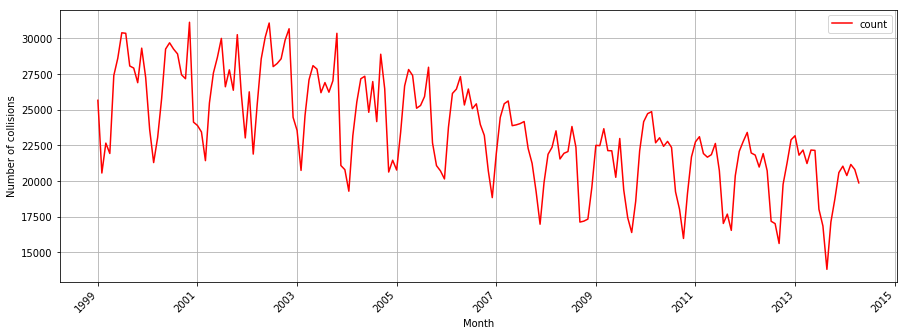

In [23]:
plot_collisions_month = collisions_month_pandas_df.plot(figsize=(15,5),x="Date",y="count",color='red')
date_arr = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015]
plot_collisions_month.set_xticklabels(date_arr,ha='right',rotation = 45)
plot_collisions_month.set_xlabel("Month")
plot_collisions_month.set_ylabel("Number of collisions");
plot_collisions_month.grid(axis='both')

# No. of collisions grouped by severity in a month

In [24]:
severity = df.select(concat(col("C_YEAR"), lit("-"), col("C_MNTH")).alias("Date"), "C_SEV")
severity = severity.groupBy("Date","C_SEV").count().sort("Date")

severity_high = severity.filter(col("C_SEV") == 1)
severity_high.show(5,False)

severity_low = severity.filter(col("C_SEV") == 2)
severity_low.show(5,False)

+-------+-----+-----+
|Date   |C_SEV|count|
+-------+-----+-----+
|1999-01|1    |326  |
|1999-02|1    |375  |
|1999-03|1    |476  |
|1999-04|1    |329  |
|1999-05|1    |508  |
+-------+-----+-----+
only showing top 5 rows

+-------+-----+-----+
|Date   |C_SEV|count|
+-------+-----+-----+
|1999-01|2    |25324|
|1999-02|2    |20182|
|1999-03|2    |22175|
|1999-04|2    |21597|
|1999-05|2    |26876|
+-------+-----+-----+
only showing top 5 rows



In [25]:
severity_high_pandas_df = severity_high.select("*").toPandas()
severity_low_pandas_df = severity_low.select("*").toPandas()

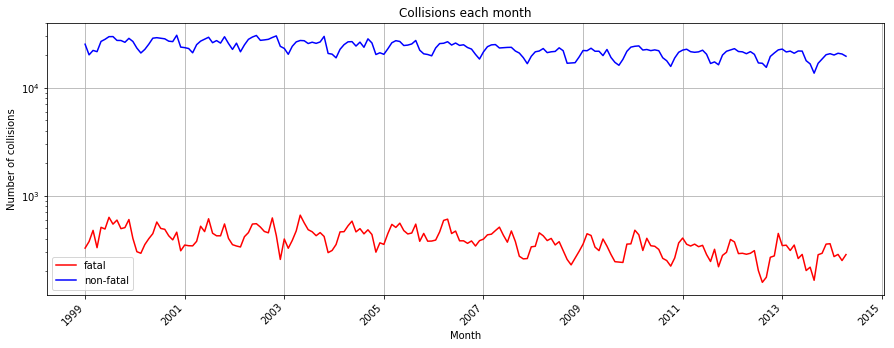

In [161]:
plot_severity_high = severity_high_pandas_df.plot(figsize=(15,5),logy = True, label = "fatal", x="Date",y="count",color='red')
plot_severity_low = severity_low_pandas_df.plot(ax = plot_severity_high, logy = True, label = "non-fatal", figsize=(15,5),x="Date",y="count",title='Collisions each month',color='blue')
date_arr = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015]
plot_severity_high.set_xticklabels(date_arr,ha='right',rotation = 45)
plot_severity_high.set_xlabel("Month")
plot_severity_high.set_ylabel("Number of collisions");
plot_severity_high.grid(axis='both')

# No. of Collisions depending upon weather conditions

In [27]:
collisions_weather = df.select(col("C_WTHR").alias("Weather_Condition")).groupBy("Weather_Condition").count()
collisions_weather.sort("count").show(collisions_month.count(),False)

+-----------------+-------+
|Weather_Condition|count  |
+-----------------+-------+
|Q                |12082  |
|7                |12370  |
|5                |24483  |
|U                |55663  |
|6                |64884  |
|4                |289629 |
|2                |440478 |
|3                |470276 |
|1                |3135972|
+-----------------+-------+



1 Clear and sunny
2 Overcast, cloudy but no precipitation
3 Raining
4 Snowing, not including drifting snow
5 Freezing rain, sleet, hail
6 Visibility limitation e.g. drifting snow, fog, smog, dust, smoke, mist
7 Strong wind
Q Choice is other than the preceding values
U Unknown
X Jurisdiction does not provide this data element

# Severity of collisions based on weather

In [28]:
sev_collisions_weather = df.select(col("C_WTHR").alias("Weather_Condition"),col("C_SEV")).groupBy("Weather_Condition","C_SEV").count()
sev_collisions_weather = sev_collisions_weather.filter((col("Weather_Condition") != 'Q') & (col("Weather_Condition") != 'U')).sort("Weather_Condition")

sev_high_collisions_weather = sev_collisions_weather.filter(col("C_SEV") == 1)
sev_low_collisions_weather = sev_collisions_weather.filter(col("C_SEV") == 2)

sev_high_collisions_weather.show(sev_high_collisions_weather.count(),False)
sev_low_collisions_weather.show(sev_low_collisions_weather.count(),False)

+-----------------+-----+-----+
|Weather_Condition|C_SEV|count|
+-----------------+-----+-----+
|1                |1    |48522|
|2                |1    |9458 |
|3                |1    |6035 |
|4                |1    |5646 |
|5                |1    |667  |
|6                |1    |2609 |
|7                |1    |433  |
+-----------------+-----+-----+

+-----------------+-----+-------+
|Weather_Condition|C_SEV|count  |
+-----------------+-----+-------+
|1                |2    |3087450|
|2                |2    |431020 |
|3                |2    |464241 |
|4                |2    |283983 |
|5                |2    |23816  |
|6                |2    |62275  |
|7                |2    |11937  |
+-----------------+-----+-------+



In [29]:
sev_high_collisions_weather_pandas_df = sev_high_collisions_weather.select("*").toPandas()
sev_low_collisions_weather_pandas_df = sev_low_collisions_weather.select("*").toPandas()

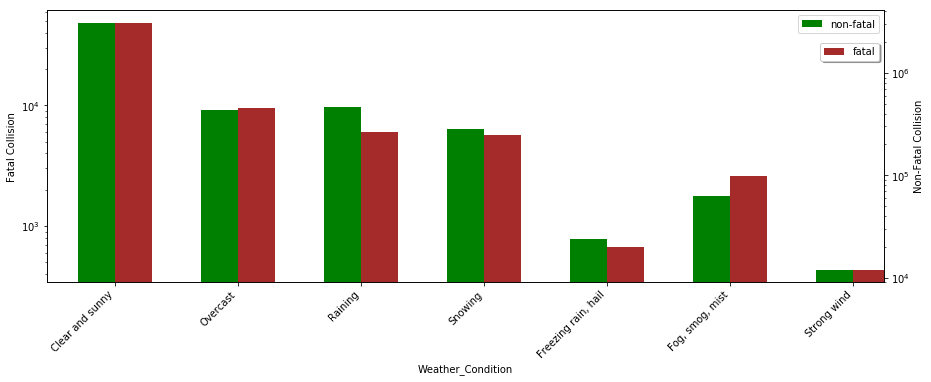

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

weather_type = ['Clear and sunny','Overcast','Raining','Snowing','Freezing rain, hail','Fog, smog, mist',
            'Strong wind']


plot_severity_high_weather = sev_high_collisions_weather_pandas_df.plot.bar(logy = True, position = 0, ax = ax, figsize=(15,5) , label = "fatal", x="Weather_Condition",y="count",width = width,color='brown')
plot_severity_low_weather = sev_low_collisions_weather_pandas_df.plot.bar(logy = True, position = 1, ax = ax2, label = "non-fatal", figsize=(15,5),x="Weather_Condition",y="count", width = width,color='green')

ax.set_xticklabels(weather_type,ha='right',rotation = 45)
ax.set_ylabel('Fatal Collision')
ax2.set_ylabel('Non-Fatal Collision')
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.9),fancybox=True, shadow=True, ncol=5)

# Collision Severity by Road Configration

In [31]:
sev_collisions_rcfg = df.select(col("C_RCFG").alias("Road_Configration"),col("C_SEV")).groupBy("Road_Configration","C_SEV").count()
sev_collisions_rcfg = sev_collisions_rcfg.sort("Road_Configration")

sev_high_collisions_rcfg = sev_collisions_rcfg.filter(col("C_SEV") == 1)
sev_low_collisions_rcfg = sev_collisions_rcfg.filter(col("C_SEV") == 2)

sev_high_collisions_rcfg.show(sev_high_collisions_rcfg.count(),False)
sev_low_collisions_rcfg.show(sev_low_collisions_rcfg.count(),False)

+-----------------+-----+-----+
|Road_Configration|C_SEV|count|
+-----------------+-----+-----+
|01               |1    |44673|
|02               |1    |19558|
|03               |1    |1927 |
|04               |1    |560  |
|05               |1    |854  |
|06               |1    |165  |
|07               |1    |72   |
|08               |1    |48   |
|09               |1    |9    |
|10               |1    |9    |
|QQ               |1    |2070 |
|UU               |1    |4098 |
+-----------------+-----+-----+

+-----------------+-----+-------+
|Road_Configration|C_SEV|count  |
+-----------------+-----+-------+
|01               |2    |1586519|
|02               |2    |2065600|
|03               |2    |226941 |
|04               |2    |14199  |
|05               |2    |38728  |
|06               |2    |4376   |
|07               |2    |544    |
|08               |2    |9237   |
|09               |2    |1255   |
|10               |2    |342    |
|QQ               |2    |89819  |
|UU        

01 Non-intersection e.g. 'mid-block'
02 At an intersection of at least two public roadways
03 Intersection with parking lot entrance/exit, private driveway or laneway
04 Railroad level crossing
05 Bridge, overpass, viaduct
06 Tunnel or underpass
07 Passing or climbing lane
08 Ramp
09 Traffic circle
10 Express lane of a freeway system
11 Collector lane of a freeway system
12 Transfer lane of a freeway system
QQ Choice is other than the preceding values
UU Unknown
XX Jurisdiction does not provide this data element

In [32]:
sev_high_collisions_rcfg_pandas_df = sev_high_collisions_rcfg.select("*").toPandas()
sev_low_collisions_rcfg_pandas_df = sev_low_collisions_rcfg.select("*").toPandas()

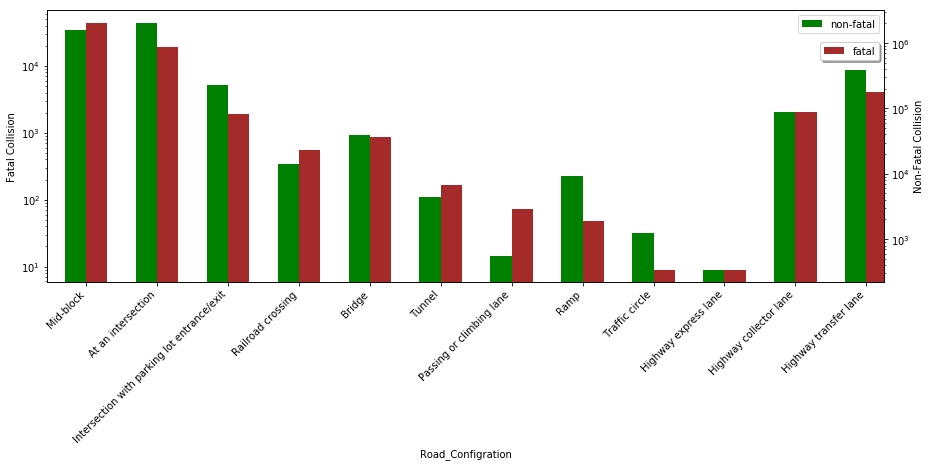

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

rcfg_type = ['Mid-block','At an intersection','Intersection with parking lot entrance/exit',
            'Railroad crossing','Bridge','Tunnel','Passing or climbing lane',
             'Ramp','Traffic circle','Highway express lane',
             'Highway collector lane','Highway transfer lane']

plot_severity_high_rcfg = sev_high_collisions_rcfg_pandas_df.plot.bar(logy = True, position = 0, ax = ax, figsize=(15,5) , label = "fatal", x="Road_Configration",y="count",width = width,color='brown')
plot_severity_low_rcfg = sev_low_collisions_rcfg_pandas_df.plot.bar(logy = True, position = 1, ax = ax2, label = "non-fatal", figsize=(15,5),x="Road_Configration",y="count", width = width,color='green')
ax.set_xticklabels(rcfg_type,ha='right',rotation=45)
ax.set_ylabel('Fatal Collision')
ax2.set_ylabel('Non-Fatal Collision')
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.9),fancybox=True, shadow=True, ncol=5)

# No. of Collisions per year by Gender

In [34]:
collisions_sex_year = df.select(col("P_SEX").alias("Sex"), col("C_YEAR").alias("Year")).filter((col("Sex") == "M") | (col("Sex") == "F")).groupBy("Sex","Year").count().sort("Year")

collisions_sex_year_male = collisions_sex_year.filter(col("Sex") == "M")
collisions_sex_year_female = collisions_sex_year.filter(col("Sex") == "F")

collisions_sex_year_male.show(5,False)
collisions_sex_year_female.show(5,False)

+---+----+------+
|Sex|Year|count |
+---+----+------+
|M  |1999|174198|
|M  |2000|175899|
|M  |2001|171031|
|M  |2002|176120|
|M  |2003|168741|
+---+----+------+
only showing top 5 rows

+---+----+------+
|Sex|Year|count |
+---+----+------+
|F  |1999|139268|
|F  |2000|145383|
|F  |2001|142317|
|F  |2002|147664|
|F  |2003|142059|
+---+----+------+
only showing top 5 rows



In [35]:
collisions_sex_year_male_pandas_df = collisions_sex_year_male.select("*").toPandas()
collisions_sex_year_female_pandas_df = collisions_sex_year_female.select("*").toPandas()

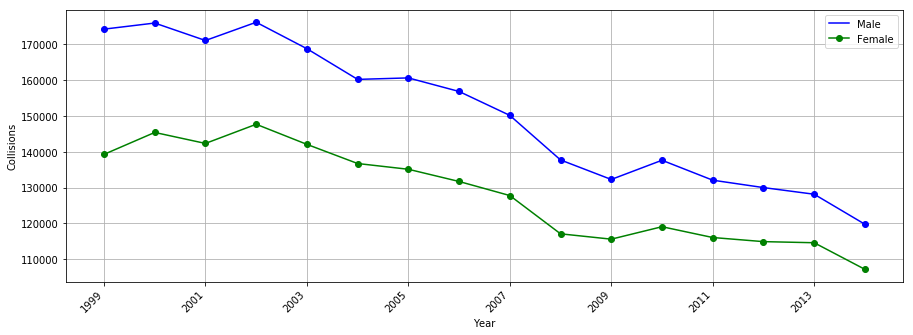

In [36]:
year_arr = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015]

plot_collisions_sex_year_male = collisions_sex_year_male_pandas_df.plot(figsize=(15,5) , marker = 'o' ,label = "Male", x="Year",y="count",color='blue')
plot_collisions_sex_year_female = collisions_sex_year_female_pandas_df.plot(ax = plot_collisions_sex_year_male,  marker = 'o' ,label = "Female", figsize=(15,5),x="Year",y="count",color='green')
plot_collisions_sex_year_male.set_xticklabels(year_arr,ha='right',rotation=45)
plot_collisions_sex_year_male.set_ylabel('Collisions')
plot_collisions_sex_year_male.grid(axis='both')

# Modeling Severity of Accidents using pyspark.ml

In [37]:
################################
###Cleaning Data for modeling###
################################

def clean_data(df, name):
    return df.select("*").filter(col(name).cast("int").isNotNull()).withColumn(name, df[name].cast(IntegerType()))

Collision_elements = ['C_YEAR','C_MNTH','C_WDAY','C_HOUR','C_SEV','C_VEHS','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF']
Vehicle_elements = ['V_ID','V_TYPE','V_YEAR',]
Personal_elements = ['P_ID','P_AGE','P_PSN','P_ISEV','P_SAFE','P_USER']

for element in Collision_elements:
    df = clean_data(df,element)
    
for element in Vehicle_elements:
    df = clean_data(df,element)
    
for element in Personal_elements:
    df = clean_data(df,element)

In [38]:
#Converting features to a Dense Vector
input_schema = ['C_VEHS','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF']

assembler = VectorAssembler(
    inputCols = input_schema,
    outputCol ="features")

transformed = assembler.transform(df).select(col("C_SEV").alias("label"), col("features"))

transformed.select("*").show(10,False)

+-----+-------------------------------+
|label|features                       |
+-----+-------------------------------+
|2    |[2.0,34.0,2.0,1.0,1.0,1.0,1.0] |
|2    |[2.0,34.0,2.0,1.0,1.0,1.0,1.0] |
|2    |[1.0,3.0,3.0,1.0,1.0,3.0,5.0]  |
|2    |[2.0,1.0,2.0,3.0,2.0,4.0,18.0] |
|2    |[2.0,1.0,2.0,3.0,2.0,4.0,18.0] |
|2    |[3.0,33.0,2.0,4.0,2.0,4.0,18.0]|
|2    |[2.0,1.0,2.0,1.0,1.0,1.0,6.0]  |
|2    |[2.0,21.0,2.0,1.0,2.0,1.0,18.0]|
|2    |[2.0,21.0,2.0,1.0,2.0,1.0,18.0]|
|2    |[1.0,4.0,5.0,1.0,5.0,1.0,18.0] |
+-----+-------------------------------+
only showing top 10 rows



In [39]:
###################
# test train split#
################### 
unbaised_df = transformed.sort("label").limit(180000)
train_data, test_data = unbaised_df.randomSplit([0.8,0.2],seed=1234)

train_size = train_data.count()
test_size = test_data.count()

print("Size of train dataset:",train_size)
print("Size of test dataset:",test_size)

Size of train dataset: 144047
Size of test dataset: 35953


In [115]:
####################
# Fitting the model#
####################

rf = RandomForestClassifier( labelCol="label", numTrees=100, maxDepth=5, seed=42)

model_rf = rf.fit(train_data)

In [116]:
###################################
# Selecting Most important Feature#
###################################

max_index = np.argmax(np.array(model_rf.featureImportances))

print("Most important Collision Feature:",input_schema[max_index])

Most important Collision Feature: C_CONF


In [139]:
weight_arr = np.array(model_rf.featureImportances)
weight_arr_scaled = weight_arr*100/weight_arr.sum()

Effect of Various Variables on Severity 

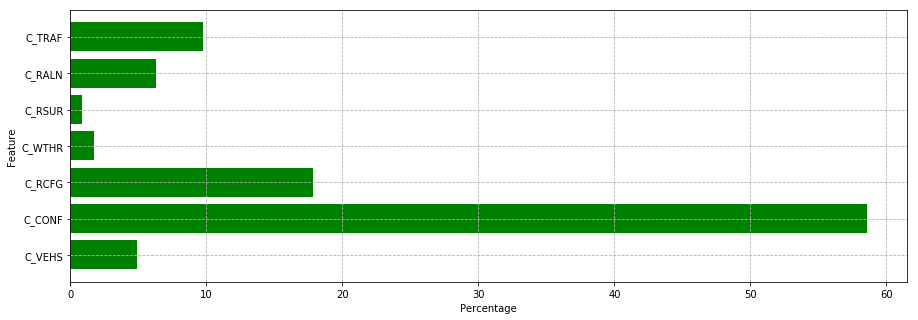

In [140]:
fig = plt.figure(figsize=(15, 5))
plt.barh(input_schema, width = weight_arr_scaled, color = "green")
plt.xlabel("Percentage")
plt.ylabel("Feature")
plt.grid(linestyle='dashed')

In [43]:
##############
# Predicting #
##############
predicted_rf = model_rf.transform(test_data)

In [44]:
correct = predicted_rf.select("prediction","label").filter(col("prediction") ==  col("label")).count()

In [45]:
accuracy = (correct/test_size)*100 
print(accuracy)

80.59410897560704


# Relation between Severity of Collision and Safety Devices used 

In [46]:
sev_collisions_sd = df.select(col("P_SAFE").alias("Safety_Device"),col("C_SEV")).groupBy(col("Safety_Device"),"C_SEV").count()
sev_collisions_sd = sev_collisions_sd.sort("Safety_Device")

sev_high_collisions_sd = sev_collisions_sd.filter(col("C_SEV") == 1)
sev_low_collisions_sd = sev_collisions_sd.filter(col("C_SEV") == 2)

sev_high_collisions_sd.show(5,False)
sev_low_collisions_sd.show(5,False)

+-------------+-----+-----+
|Safety_Device|C_SEV|count|
+-------------+-----+-----+
|1            |1    |10286|
|2            |1    |39810|
|9            |1    |1811 |
|12           |1    |519  |
|13           |1    |1479 |
+-------------+-----+-----+

+-------------+-----+-------+
|Safety_Device|C_SEV|count  |
+-------------+-----+-------+
|1            |2    |85445  |
|2            |2    |3055572|
|9            |2    |44495  |
|10           |2    |21     |
|12           |2    |13463  |
+-------------+-----+-------+
only showing top 5 rows



In [47]:
sev_high_collisions_sd_pandas_df = sev_high_collisions_sd.select("*").toPandas()
sev_low_collisions_sd_pandas_df = sev_low_collisions_sd.select("*").toPandas()

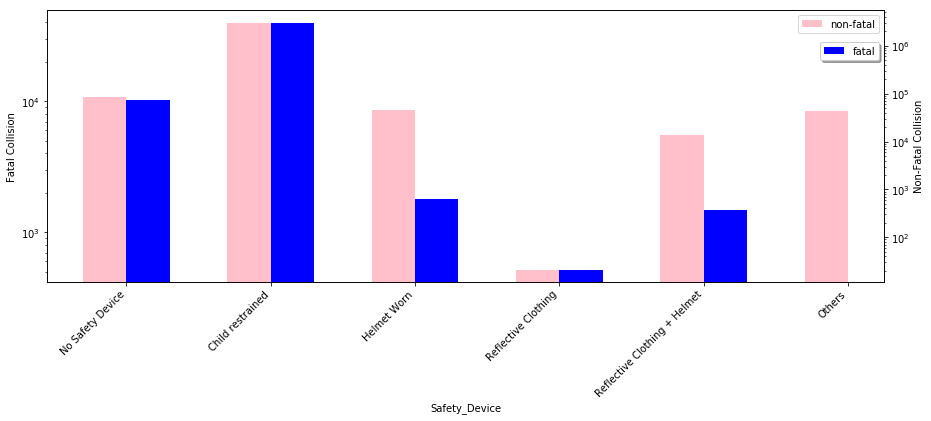

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

rcfg_type = ["No Safety Device", "Child restrained", "Helmet Worn", "Reflective Clothing", "Reflective Clothing + Helmet", "Others", "Public Transport"]

plot_severity_high_sd = sev_high_collisions_sd_pandas_df.plot.bar(logy = True, position = 0, ax = ax, figsize=(15,5) , label = "fatal", x="Safety_Device",y="count",width = width,color='blue')
plot_severity_low_sd = sev_low_collisions_sd_pandas_df.plot.bar(logy = True, position = 1, ax = ax2, label = "non-fatal", figsize=(15,5),x="Safety_Device",y="count", width = width,color='pink')
ax.set_xticklabels(rcfg_type,ha='right',rotation=45)
ax.set_ylabel('Fatal Collision')
ax2.set_ylabel('Non-Fatal Collision')
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.9),fancybox=True, shadow=True, ncol=5)

# Road Alignment and No.of Vehicles Involved

In [49]:
seed = 6

def chunk(count):
    return ((count/seed))

In [50]:
collisions_rd_cv = df.select(chunk(col("C_VEHS")).alias("Count_Group"),col("C_RALN"))
collisions_rd_cv = collisions_rd_cv.withColumn("Count_Group", collisions_rd_cv["Count_Group"].cast(IntegerType()))
collisions_rd_cv = collisions_rd_cv.groupBy(col("Count_Group"),"C_RALN").count().sort("Count_Group")
collisions_rd_cv.show(10,False)

collisions_rd_cv_1 = collisions_rd_cv.filter(col("C_RALN") == 1)
collisions_rd_cv_2 = collisions_rd_cv.filter((col("C_RALN") == 2))
collisions_rd_cv_3 = collisions_rd_cv.filter((col("C_RALN") == 3))
collisions_rd_cv_4 = collisions_rd_cv.filter((col("C_RALN") == 4))
collisions_rd_cv_5 = collisions_rd_cv.filter((col("C_RALN") == 5))
collisions_rd_cv_6 = collisions_rd_cv.filter((col("C_RALN") == 6))

+-----------+------+-------+
|Count_Group|C_RALN|count  |
+-----------+------+-------+
|0          |3     |211897 |
|0          |2     |355292 |
|0          |1     |2555607|
|0          |6     |12527  |
|0          |5     |17893  |
|0          |4     |127733 |
|1          |6     |54     |
|1          |1     |9840   |
|1          |3     |476    |
|1          |5     |216    |
+-----------+------+-------+
only showing top 10 rows



In [51]:
collisions_rd_cv_1_pd = collisions_rd_cv_1.toPandas()
collisions_rd_cv_2_pd = collisions_rd_cv_2.toPandas()
collisions_rd_cv_3_pd = collisions_rd_cv_3.toPandas()
collisions_rd_cv_4_pd = collisions_rd_cv_4.toPandas()
collisions_rd_cv_5_pd = collisions_rd_cv_5.toPandas()
collisions_rd_cv_6_pd = collisions_rd_cv_6.toPandas()

In [52]:
collisions_rd_cv_1_pd.head(5)

,Count_Group,C_RALN,count
0,0,1,2555607
1,1,1,9840
2,2,1,574
3,3,1,249
4,4,1,109


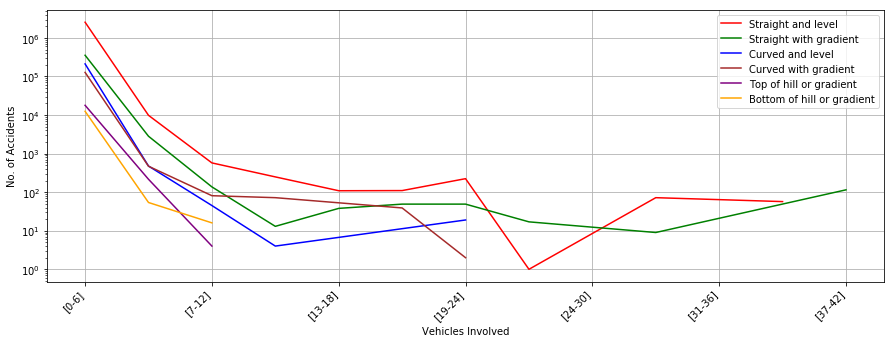

In [53]:
year_group_arr = ["Start","[0-6]","[7-12]","[13-18]","[19-24]","[24-30]","[31-36]","[37-42]"]

plot_collisions_rd_cv_1_pd = collisions_rd_cv_1_pd.plot(logy=True, figsize=(15,5) , label = "Straight and level", x="Count_Group",y="count",color='red')
plot_collisions_rd_cv_2_pd = collisions_rd_cv_2_pd.plot(ax = plot_collisions_rd_cv_1_pd, label = "Straight with gradient", figsize=(15,5),x="Count_Group",y="count",color='green')
plot_collisions_rd_cv_3_pd = collisions_rd_cv_3_pd.plot(ax = plot_collisions_rd_cv_1_pd, label = "Curved and level", figsize=(15,5),x="Count_Group",y="count",color='blue')
plot_collisions_rd_cv_4_pd = collisions_rd_cv_4_pd.plot(ax = plot_collisions_rd_cv_1_pd, label = "Curved with gradient", figsize=(15,5),x="Count_Group",y="count",color='brown')
plot_collisions_rd_cv_5_pd = collisions_rd_cv_5_pd.plot(ax = plot_collisions_rd_cv_1_pd, label = "Top of hill or gradient", figsize=(15,5),x="Count_Group",y="count",color='purple')
plot_collisions_rd_cv_6_pd = collisions_rd_cv_6_pd.plot(ax = plot_collisions_rd_cv_1_pd, label = "Bottom of hill or gradient", figsize=(15,5),x="Count_Group",y="count",color='orange')

plot_collisions_rd_cv_1_pd.set_xticklabels(year_group_arr,ha='right',rotation=45)
plot_collisions_rd_cv_1_pd.set_xlabel('Vehicles Involved')
plot_collisions_rd_cv_1_pd.set_ylabel('No. of Accidents')
plot_collisions_rd_cv_1_pd.grid(axis='both')

# Analysis Using Vehical Type

Number of Collisions by Vehicle Type

In [54]:
collisions_vt = df.select(col("V_TYPE").alias("Vehicle_Type")).groupBy("Vehicle_Type").count().sort("Vehicle_Type")
collisions_vt.show(10,False)

+------------+-------+
|Vehicle_Type|count  |
+------------+-------+
|1           |2978541|
|5           |40615  |
|6           |102871 |
|7           |39577  |
|8           |36380  |
|9           |12351  |
|10          |659    |
|11          |27638  |
|14          |51748  |
|17          |2946   |
+------------+-------+
only showing top 10 rows



In [55]:
collisions_vt_pd = collisions_vt.toPandas()

Text(0,0.5,'No. of Accidents')

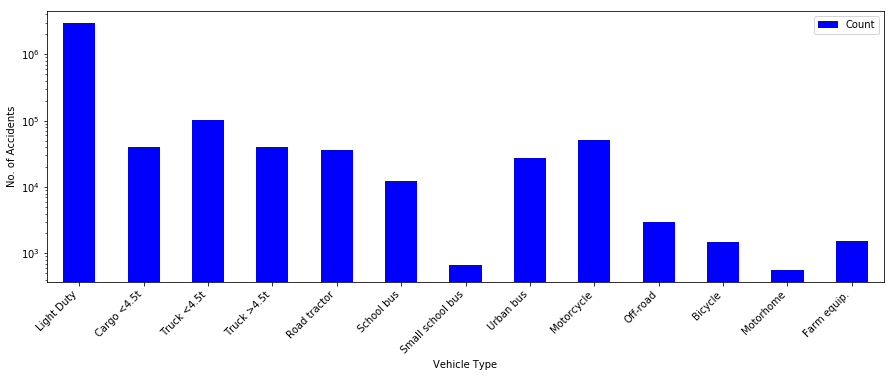

In [56]:
vt_arr = ['Light Duty', 'Cargo <4.5t', 'Truck <4.5t','Truck >4.5t', 'Road tractor', 'School bus',
          'Small school bus', 'Urban bus', 'Motorcycle',
          'Off-road', 'Bicycle', 'Motorhome', 'Farm equip.',
          'Constru. equip.', 'Fire engine', 'Snowmobile',
          'Street car']

plot_collisions_vt = collisions_vt_pd.plot.bar(logy=True, figsize=(15,5) , label = "Count", x="Vehicle_Type",y="count",color='blue')

plot_collisions_vt.set_xticklabels(vt_arr,ha='right',rotation=45)
plot_collisions_vt.set_xlabel('Vehicle Type')
plot_collisions_vt.set_ylabel('No. of Accidents')

Vehicle Type and Severity

In [57]:
sev_collisions_vt = df.select(col("V_TYPE").alias("Vehicle_Type"),col("C_SEV")).groupBy("Vehicle_Type","C_SEV").count().sort("Vehicle_Type")

sev_high_collisions_vt = sev_collisions_vt.filter(col("C_SEV") == 1)
sev_low_collisions_vt = sev_collisions_vt.filter(col("C_SEV") == 2)

sev_high_collisions_vt.show(5,False)
sev_low_collisions_vt.show(5,False)

+------------+-----+-----+
|Vehicle_Type|C_SEV|count|
+------------+-----+-----+
|1           |1    |43338|
|5           |1    |651  |
|6           |1    |2259 |
|7           |1    |1658 |
|8           |1    |2650 |
+------------+-----+-----+
only showing top 5 rows

+------------+-----+-------+
|Vehicle_Type|C_SEV|count  |
+------------+-----+-------+
|1           |2    |2935203|
|5           |2    |39964  |
|6           |2    |100612 |
|7           |2    |37919  |
|8           |2    |33730  |
+------------+-----+-------+
only showing top 5 rows



In [58]:
sev_high_collisions_vt_pd = sev_high_collisions_vt.toPandas()
sev_low_collisions_vt_pd = sev_low_collisions_vt.toPandas()

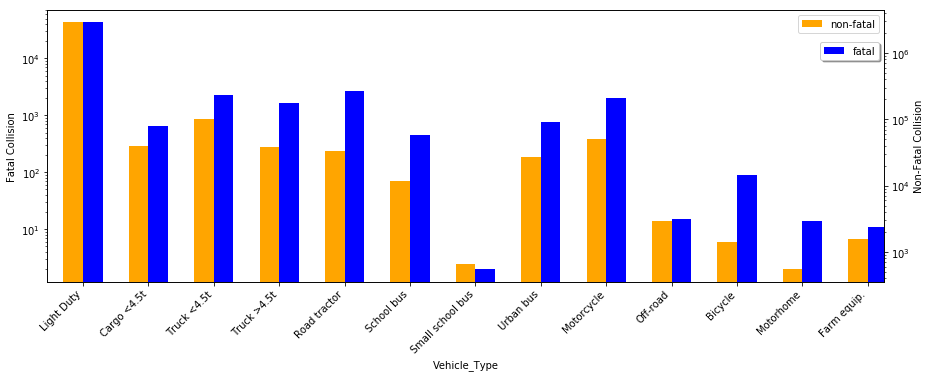

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

plot_sev_high_collisions_vt = sev_high_collisions_vt_pd.plot.bar(logy = True, position = 0, ax = ax, figsize=(15,5) , label='fatal', x="Vehicle_Type",y="count",width = width,color='blue')
plot_sev_low_collisions_vt = sev_low_collisions_vt_pd.plot.bar(logy = True, position = 1, ax = ax2, label = "non-fatal", figsize=(15,5),x="Vehicle_Type",y="count", width = width,color='orange')
ax.set_xticklabels(vt_arr,ha='right',rotation=45)
ax.set_ylabel('Fatal Collision')
ax2.set_ylabel('Non-Fatal Collision')
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.9),fancybox=True, shadow=True, ncol=5)

Collisions analysis of 2-wheelers (Bicycle and Motorcycle) by vehicle type per year

In [60]:
collisions_vt_time = df.select(col("V_TYPE").alias("Vehicle_Type"),"C_YEAR").groupBy("Vehicle_Type","C_YEAR").count().sort("C_YEAR")

collisions_vt_time.show(5,False)

collisions_vt_time_mc = collisions_vt_time.filter(col("Vehicle_Type") == 14)
collisions_vt_time_bc = collisions_vt_time.filter(col("Vehicle_Type") == 17)

collisions_vt_time_mc.show(5,False)
collisions_vt_time_bc.show(5,False)

+------------+------+-----+
|Vehicle_Type|C_YEAR|count|
+------------+------+-----+
|9           |1999  |521  |
|6           |1999  |41429|
|5           |1999  |81   |
|14          |1999  |3741 |
|11          |1999  |1328 |
+------------+------+-----+
only showing top 5 rows

+------------+------+-----+
|Vehicle_Type|C_YEAR|count|
+------------+------+-----+
|14          |1999  |3741 |
|14          |2000  |2400 |
|14          |2001  |2554 |
|14          |2002  |2520 |
|14          |2003  |2606 |
+------------+------+-----+
only showing top 5 rows

+------------+------+-----+
|Vehicle_Type|C_YEAR|count|
+------------+------+-----+
|17          |1999  |552  |
|17          |2000  |204  |
|17          |2001  |204  |
|17          |2002  |139  |
|17          |2003  |132  |
+------------+------+-----+
only showing top 5 rows



In [61]:
collisions_vt_time_mc_pd = collisions_vt_time_mc.toPandas()
collisions_vt_time_bc_pd = collisions_vt_time_bc.toPandas()

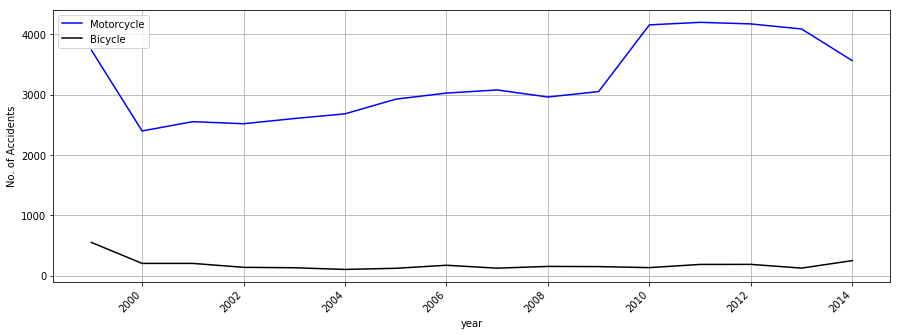

In [62]:
year_arr_even = ["1998","2000","2002","2004","2006","2008","2010","2012","2014"]
plot_collisions_vt_time_mc = collisions_vt_time_mc_pd.plot( figsize=(15,5) , label = "Motorcycle", x="C_YEAR",y="count",color='blue')
plot_collisions_vt_time_bc = collisions_vt_time_bc_pd.plot(ax = plot_collisions_vt_time_mc, label = "Bicycle", figsize=(15,5),x="C_YEAR",y="count",color='black')

plot_collisions_vt_time_mc.set_xticklabels(year_arr_even,ha='right',rotation=45)
plot_collisions_vt_time_mc.set_xlabel('year')
plot_collisions_vt_time_mc.set_ylabel('No. of Accidents')
plot_collisions_vt_time_mc.grid(axis='both')

# Most Imp feature according to the classifier - Collision Configration vs requirement of medical treatment

In [63]:
collisions_conf_mt = df.select("C_CONF","P_ISEV").filter(col("P_ISEV") != 3).groupBy("C_CONF","P_ISEV").count().sort("C_CONF")

collisions_conf_mt_no = collisions_conf_mt.filter(col("P_ISEV") == 1)
collisions_conf_mt_yes = collisions_conf_mt.filter(col("P_ISEV") == 2)
collisions_conf_mt.show(5,False)

+------+------+-----+
|C_CONF|P_ISEV|count|
+------+------+-----+
|1     |2     |20939|
|1     |1     |11094|
|2     |2     |47498|
|2     |1     |22524|
|3     |1     |11828|
+------+------+-----+
only showing top 5 rows



In [64]:
collisions_conf_mt_no_pd = collisions_conf_mt_no.toPandas()
collisions_conf_mt_yes_pd = collisions_conf_mt_yes.toPandas()

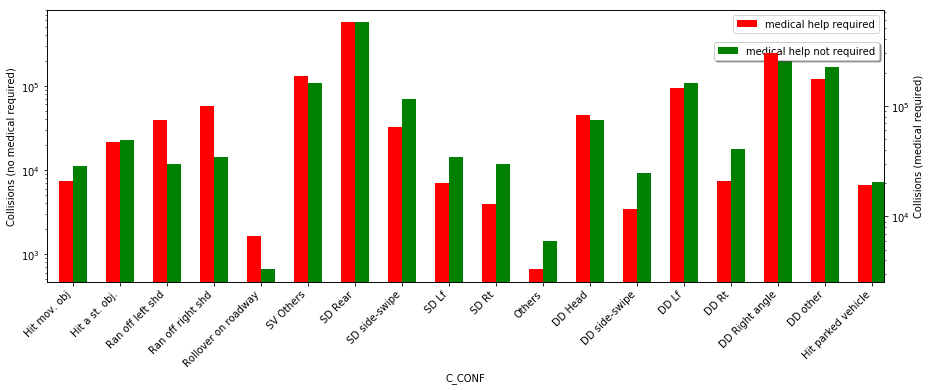

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

conf_arr = ['Hit mov. obj','Hit a st. obj.','Ran off left shd',
         'Ran off right shd','Rollover on roadway',
         'SV Others','SD Rear','SD side-swipe',
         'SD Lf','SD Rt','Others','DD Head',
         'DD side-swipe','DD Lf','DD Rt','DD Right angle',
         'DD other','Hit parked vehicle']

plot_collisions_conf_mt_no = collisions_conf_mt_no_pd.plot.bar(logy = True, position = 0, ax = ax, figsize=(15,5) , label="medical help not required", x="C_CONF",y="count",width = width,color='green')
plot_collisions_conf_mt_yes = collisions_conf_mt_yes_pd.plot.bar(logy = True, position = 1, ax = ax2, label = "medical help required", figsize=(15,5),x="C_CONF",y="count", width = width,color='red')
ax.set_xticklabels(conf_arr,ha='right',rotation=45)
ax.set_ylabel('Collisions (no medical required)')
ax2.set_ylabel('Collisions (medical required)')
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.9),fancybox=True, shadow=True, ncol=5)

# Generalized Modeling Utility function

In [157]:
def pre_processing(df, input_schema, label, limit):
    assembler = VectorAssembler(inputCols = input_schema, outputCol = "features")
    transformed = assembler.transform(df).select(col(label).alias("label"), col("features"))
    train_data, test_data = transformed.sort("label").limit(limit).randomSplit([0.8,0.2],seed=1234)
    return train_data, test_data

def modeling(df, input_schema, label, limit = 10000):
    train_data, test_data = pre_processing(df, input_schema, label, limit)
    
    rf = RandomForestClassifier( labelCol="label", numTrees=10, maxDepth=3, seed=42)
    model_rf = rf.fit(train_data)
    
    max_index = np.argmax(np.array(model_rf.featureImportances))
    mif = input_schema[max_index]
    predicted_rf = model_rf.transform(test_data)
    
    correct = predicted_rf.select("prediction","label").filter(col("prediction") ==  col("label")).count()
    accuracy = (correct/predicted_rf.count())*100 
    
    return model_rf, mif, accuracy

Modeling 'Need of Medical attention'

In [158]:
input_schema = ['C_VEHS','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF']
label = "P_ISEV"
model_rf, mif, accuracy = modeling(df.filter((col("P_ISEV")==1) | (col("P_ISEV")==2)), input_schema, label)
print("Most of important feature contibuting towards requirment of medical support is",mif)
print("Accuracy of Modeling:",accuracy)

Most of important feature contibuting towards requirment of medical support is C_VEHS
Accuracy of Modeling: 100.0


# Effect of Age of Vehicle on Collisions using Feature Engineering

In [151]:
collisions_count_vht = df.select((col("C_YEAR") - col("V_YEAR")).alias("time")).filter((col("time") >= 0) & (col("time") <= 14)).groupBy("time").count().sort("time")

collisions_count_vht.show(5,False)

+----+------+
|time|count |
+----+------+
|0   |188161|
|1   |242910|
|2   |235426|
|3   |225625|
|4   |230052|
+----+------+
only showing top 5 rows



In [152]:
collisions_count_vht_pd = collisions_count_vht.toPandas()

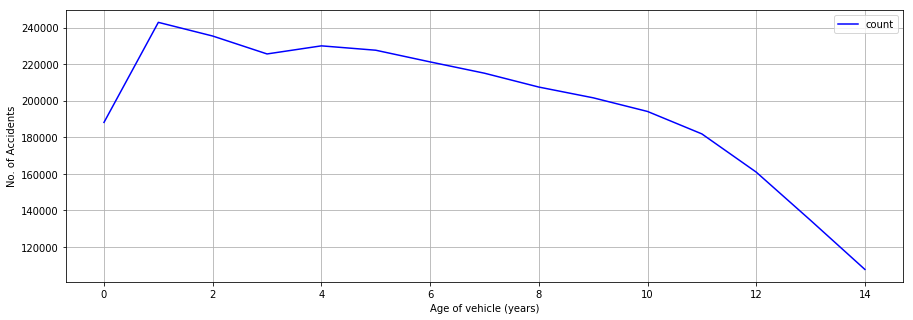

In [153]:
#year_arr_even = ["1998","2000","2002","2004","2006","2008","2010","2012","2014"]
plot_collisions_count_vht = collisions_count_vht_pd.plot( figsize=(15,5) ,  x="time",y="count",color='blue')

#plot_collisions_count_vht.set_xticklabels(year_arr_even,ha='right',rotation=45)
plot_collisions_count_vht.set_xlabel('Age of vehicle (years)')
plot_collisions_count_vht.set_ylabel('No. of Accidents')
plot_collisions_count_vht.grid(axis='both')